# Data classification using ML models

In [58]:
# Imports
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LinearSVC, LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [39]:
# Build SparkSession
spark = SparkSession.builder \
    .appName("CrimesFix") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "16") \
    .getOrCreate()

In [40]:
df_test = spark.read.parquet("../Datasets/crimes-small-test")

## Model Evaluation

### Linear SVM Model

In [41]:
linear_model = PipelineModel.load('model-LinearSVM')

df_predictions = linear_model.transform(df_test)

df_predictions_eval = df_predictions.select('features', 
                    'rawPrediction', 'prediction', 'Arrest')

binary_evaluator = BinaryClassificationEvaluator(labelCol='Arrest',
                                                rawPredictionCol='rawPrediction',
                                                metricName='areaUnderROC')
    
area_under_ROC_linear = binary_evaluator.evaluate(df_predictions_eval)

# Print out result
print(f'Metric areaUnderROC of the linear model = {area_under_ROC_linear}')

Metric areaUnderROC of the linear model = 0.9021118928128665


In [42]:
# Counting of the kind of predictions made
df_confusion_matrix = df_predictions_eval.groupBy('prediction', 'Arrest').count()
df_confusion_matrix.show()

+----------+------+------+
|prediction|Arrest| count|
+----------+------+------+
|       0.0|     0|491830|
|       1.0|     1|110874|
|       1.0|     0| 41804|
|       0.0|     1| 45624|
+----------+------+------+



In [43]:
# Compute the confusion matrix
tp = df_confusion_matrix.filter((F.col('prediction')==1.0) & (F.col('Arrest')==1)).first()
tn = df_confusion_matrix.filter((F.col('prediction')==0.0) & (F.col('Arrest')==0)).first()
fp = df_confusion_matrix.filter((F.col('prediction')==1.0) & (F.col('Arrest')==0)).first()
fn = df_confusion_matrix.filter((F.col('prediction')==0.0) & (F.col('Arrest')==1)).first()

confmat = {'TP': 0.0, 'TN': 0.0, 'FP': 0.0, 'FN': 0.0}
if (tp):
    confmat['TP'] = tp['count'] * 1.0
if (tn):
    confmat['TN'] = tn['count'] * 1.0
if (fp):
    confmat['FP'] = fp['count'] * 1.0
if (fn):
    confmat['FN'] = fn['count'] * 1.0

# Printing the matrix
print("\nConfusion Matrix:\n")
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("", "Pred 0", "Pred 1"))
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("True 0", int(confmat['TN']), int(confmat['FP'])))
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("True 1", int(confmat['FN']), int(confmat['TP'])))
print("+" + "-" * 35 + "+")


Confusion Matrix:

+-----------------------------------+
|               | Pred 0  | Pred 1  |
+-----------------------------------+
|    True 0     | 491830  |  41804  |
+-----------------------------------+
|    True 1     |  45624  | 110874  |
+-----------------------------------+


In [44]:
# Based on the confusion matrix, computed the evaluation matrics:
#   accuracy, precision, recall, specifity and F1 score

# PS: Check divisons by 0.0
TP = confmat['TP']
TN = confmat['TN']
FP = confmat['FP']
FN = confmat['FN']

accuracy_linear = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0
precision_linear = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall_linear = TP / (TP + FN) if (TP + FN) > 0 else 0.0
specifiсity_linear = TN / (TN + FP) if (TN + FP) > 0 else 0.0
f1score_linear = 2 * precision_linear * recall_linear / (precision_linear + recall_linear) if (precision_linear + recall_linear) > 0 else 0.0

print('All evaluation metrics (rounded to 4 digits):')
print(f' Metric areaUnderROC of the Linear SVM Model = {round(area_under_ROC_linear, 4)}')
print(f' Linear Accuracy = {round(accuracy_linear, 4)}')
print(f' Linear Precision = {round(precision_linear, 4)}')
print(f' Linear Recall = {round(recall_linear, 4)}')
print(f' Linear Specificity = {round(specifiсity_linear, 4)}')
print(f' Linear F1 score = {round(f1score_linear, 4)}')

All evaluation metrics (rounded to 4 digits):
 Metric areaUnderROC of the Linear SVM Model = 0.9021
 Linear Accuracy = 0.8733
 Linear Precision = 0.7262
 Linear Recall = 0.7085
 Linear Specificity = 0.9217
 Linear F1 score = 0.7172


### Logistic Regression Classifier

In [45]:
model_logreg = PipelineModel.load('model-LogReg')

df_predictions = model_logreg.transform(df_test)

df_predictions_eval = df_predictions.select('features', 
                    'rawPrediction', 'prediction', 'Arrest')

binary_evaluator = BinaryClassificationEvaluator(labelCol='Arrest',
                                                rawPredictionCol='rawPrediction',
                                                metricName='areaUnderROC')
    
area_under_ROC_logreg = binary_evaluator.evaluate(df_predictions_eval)

# Print out result
print(f'Metric areaUnderROC of the Logistic Regression model = {area_under_ROC_logreg}')

Metric areaUnderROC of the Logistic Regression model = 0.9098001675270245


In [46]:
# Counting of the kind of predictions made
df_confusion_matrix = df_predictions_eval.groupBy('prediction', 'Arrest').count()
df_confusion_matrix.show()

+----------+------+------+
|prediction|Arrest| count|
+----------+------+------+
|       0.0|     0|471129|
|       1.0|     1|118934|
|       1.0|     0| 62505|
|       0.0|     1| 37564|
+----------+------+------+



In [47]:
# Compute the confusion matrix
tp = df_confusion_matrix.filter((F.col('prediction')==1.0) & (F.col('Arrest')==1)).first()
tn = df_confusion_matrix.filter((F.col('prediction')==0.0) & (F.col('Arrest')==0)).first()
fp = df_confusion_matrix.filter((F.col('prediction')==1.0) & (F.col('Arrest')==0)).first()
fn = df_confusion_matrix.filter((F.col('prediction')==0.0) & (F.col('Arrest')==1)).first()

confmat = {'TP': 0.0, 'TN': 0.0, 'FP': 0.0, 'FN': 0.0}
if (tp):
    confmat['TP'] = tp['count'] * 1.0
if (tn):
    confmat['TN'] = tn['count'] * 1.0
if (fp):
    confmat['FP'] = fp['count'] * 1.0
if (fn):
    confmat['FN'] = fn['count'] * 1.0

# Printing the matrix
print("\nConfusion Matrix:\n")
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("", "Pred 0", "Pred 1"))
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("True 0", int(confmat['TN']), int(confmat['FP'])))
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("True 1", int(confmat['FN']), int(confmat['TP'])))
print("+" + "-" * 35 + "+")


Confusion Matrix:

+-----------------------------------+
|               | Pred 0  | Pred 1  |
+-----------------------------------+
|    True 0     | 471129  |  62505  |
+-----------------------------------+
|    True 1     |  37564  | 118934  |
+-----------------------------------+


In [48]:
# Based on the confusion matrix, computed the evaluation matrics:
#   accuracy, precision, recall, specifity and F1 score

# PS: Check divisons by 0.0
TP = confmat['TP']
TN = confmat['TN']
FP = confmat['FP']
FN = confmat['FN']

accuracy_logreg = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0
precision_logreg = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall_logreg = TP / (TP + FN) if (TP + FN) > 0 else 0.0
specifiсity_logreg = TN / (TN + FP) if (TN + FP) > 0 else 0.0
f1score_logreg = 2 * precision_logreg * recall_logreg / (precision_logreg + recall_logreg) if (precision_logreg + recall_logreg) > 0 else 0.0

print('All evaluation metrics (rounded to 4 digits):')
print(f' Metric areaUnderROC of the Logistic Regression Model = {round(area_under_ROC_logreg, 4)}')
print(f' Linear Accuracy = {round(accuracy_logreg, 4)}')
print(f' Linear Precision = {round(precision_logreg, 4)}')
print(f' Linear Recall = {round(recall_logreg, 4)}')
print(f' Linear Specificity = {round(specifiсity_logreg, 4)}')
print(f' Linear F1 score = {round(f1score_logreg, 4)}')

All evaluation metrics (rounded to 4 digits):
 Metric areaUnderROC of the Logistic Regression Model = 0.9098
 Linear Accuracy = 0.855
 Linear Precision = 0.6555
 Linear Recall = 0.76
 Linear Specificity = 0.8829
 Linear F1 score = 0.7039


### Random Forest Classifier

In [49]:
model_rf = PipelineModel.load('model-RandomForest')

df_predictions = model_rf.transform(df_test)

df_predictions_eval = df_predictions.select('features', 
                    'rawPrediction', 'prediction', 'Arrest')

binary_evaluator = BinaryClassificationEvaluator(labelCol='Arrest',
                                                rawPredictionCol='rawPrediction',
                                                metricName='areaUnderROC')
    
area_under_ROC_rf = binary_evaluator.evaluate(df_predictions_eval)

# Print out result
print(f'Metric areaUnderROC of the Random Forest model = {area_under_ROC_rf}')

Metric areaUnderROC of the Random Forest model = 0.8761805604252068


In [50]:
# Counting of the kind of predictions made
df_confusion_matrix = df_predictions_eval.groupBy('prediction', 'Arrest').count()
df_confusion_matrix.show()

+----------+------+------+
|prediction|Arrest| count|
+----------+------+------+
|       0.0|     0|483781|
|       1.0|     1|102851|
|       1.0|     0| 49853|
|       0.0|     1| 53647|
+----------+------+------+



In [51]:
# Compute the confusion matrix
tp = df_confusion_matrix.filter((F.col('prediction')==1.0) & (F.col('Arrest')==1)).first()
tn = df_confusion_matrix.filter((F.col('prediction')==0.0) & (F.col('Arrest')==0)).first()
fp = df_confusion_matrix.filter((F.col('prediction')==1.0) & (F.col('Arrest')==0)).first()
fn = df_confusion_matrix.filter((F.col('prediction')==0.0) & (F.col('Arrest')==1)).first()

confmat = {'TP': 0.0, 'TN': 0.0, 'FP': 0.0, 'FN': 0.0}
if (tp):
    confmat['TP'] = tp['count'] * 1.0
if (tn):
    confmat['TN'] = tn['count'] * 1.0
if (fp):
    confmat['FP'] = fp['count'] * 1.0
if (fn):
    confmat['FN'] = fn['count'] * 1.0

# Printing the matrix
print("\nConfusion Matrix:\n")
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("", "Pred 0", "Pred 1"))
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("True 0", int(confmat['TN']), int(confmat['FP'])))
print("+" + "-" * 35 + "+")
print("|{:^15}|{:^9}|{:^9}|".format("True 1", int(confmat['FN']), int(confmat['TP'])))
print("+" + "-" * 35 + "+")


Confusion Matrix:

+-----------------------------------+
|               | Pred 0  | Pred 1  |
+-----------------------------------+
|    True 0     | 483781  |  49853  |
+-----------------------------------+
|    True 1     |  53647  | 102851  |
+-----------------------------------+


In [52]:
# Based on the confusion matrix, computed the evaluation matrics:
#   accuracy, precision, recall, specifity and F1 score

# PS: Check divisons by 0.0
TP = confmat['TP']
TN = confmat['TN']
FP = confmat['FP']
FN = confmat['FN']

accuracy_rf = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0
precision_rf = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall_rf = TP / (TP + FN) if (TP + FN) > 0 else 0.0
specifiсity_rf = TN / (TN + FP) if (TN + FP) > 0 else 0.0
f1score_rf = 2 * precision_rf * recall_rf / (precision_rf + recall_rf) if (precision_rf + recall_rf) > 0 else 0.0

print('All evaluation metrics (rounded to 4 digits):')
print(f' Metric areaUnderROC of the Random Forest Model = {round(area_under_ROC_rf, 4)}')
print(f' Linear Accuracy = {round(accuracy_rf, 4)}')
print(f' Linear Precision = {round(precision_rf, 4)}')
print(f' Linear Recall = {round(recall_rf, 4)}')
print(f' Linear Specificity = {round(specifiсity_rf, 4)}')
print(f' Linear F1 score = {round(f1score_rf, 4)}')

All evaluation metrics (rounded to 4 digits):
 Metric areaUnderROC of the Random Forest Model = 0.8762
 Linear Accuracy = 0.85
 Linear Precision = 0.6735
 Linear Recall = 0.6572
 Linear Specificity = 0.9066
 Linear F1 score = 0.6653


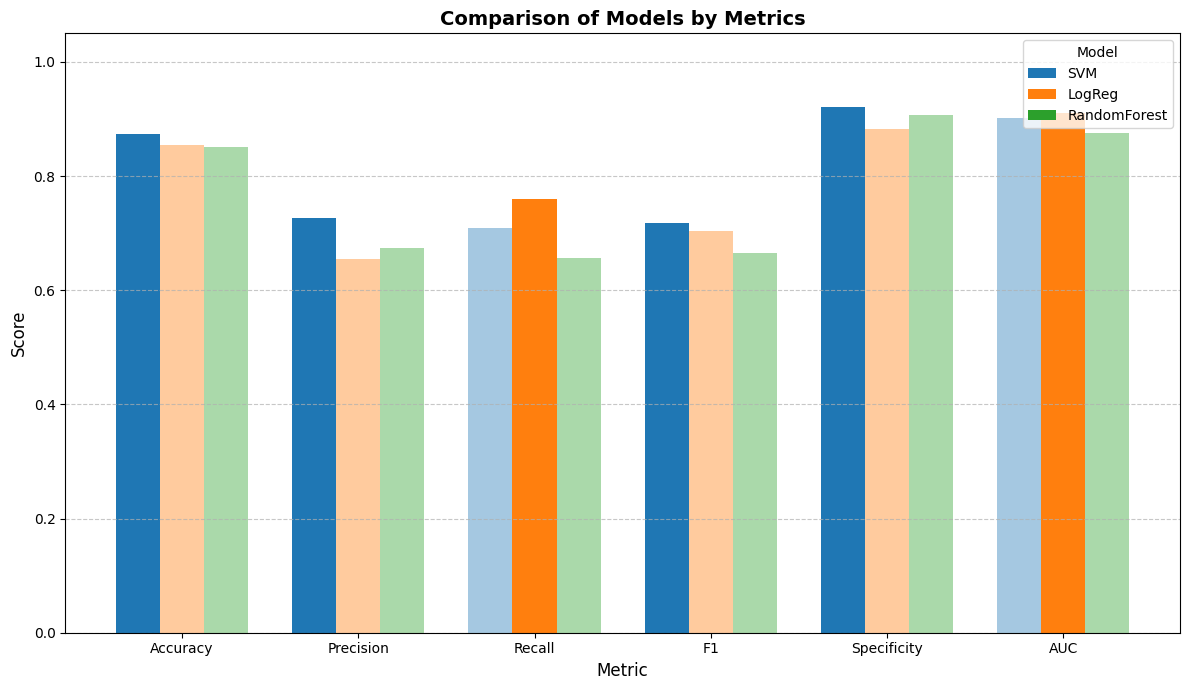

In [78]:
# Dictionary with metrics for all models
metrics = {
    'Model': ['SVM', 'LogReg', 'RandomForest'],
    'Accuracy': [accuracy_linear, accuracy_logreg, accuracy_rf],
    'Precision': [precision_linear, precision_logreg, precision_rf],
    'Recall': [recall_linear, recall_logreg, recall_rf],
    'F1': [f1score_linear, f1score_logreg, f1score_rf],
    'Specificity': [specifiсity_linear, specifiсity_logreg, specifiсity_rf],
    'AUC': [area_under_ROC_linear, area_under_ROC_logreg, area_under_ROC_rf]
}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Define the base colors for each model
base_colors = {'SVM': '#1f77b4', 'LogReg': '#ff7f0e', 'RandomForest': '#2ca02c'}

# Create a chart
fig, ax = plt.subplots(figsize=(12, 7))

# Parameters for column groups
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'AUC']
model_names = ['SVM', 'LogReg', 'RandomForest']
x = np.arange(len(metric_names))
width = 0.25

# For each metric, determine which models performed the worst
for i, metric in enumerate(metric_names):
    metric_values = df_metrics[metric].values
    model_performance = list(zip(model_names, metric_values))
    
    # Sort by metric value (descending)
    model_performance.sort(key=lambda x: x[1], reverse=True)
    
    # Determine the worst 2 models for this metric
    worst_models = {model_performance[-1][0], model_performance[-2][0]}
    
    # Draw columns for each model
    for j, model in enumerate(model_names):
        value = df_metrics[df_metrics['Model'] == model][metric].iloc[0]
        
        # Choose a color: dull for the worst models, bright for the best ones
        if model in worst_models:
            # Faint color (add transparency)
            color = base_colors[model]
            alpha = 0.4
        else:
            # Bright color
            color = base_colors[model]
            alpha = 1.0
        
        # Column position
        pos = x[i] + (j - 1) * width
        
        # Draw a column
        bar = ax.bar(pos, value, width, color=color, alpha=alpha, 
                    label=model if i == 0 else "")

# Setting the schedule
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparison of Models by Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Create a legend with base colors
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=base_colors[model], 
                                label=model) for model in model_names]
ax.legend(handles=legend_elements, title='Model', loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# Устанавливаем модели как индекс (строки)
df_metrics = df_metrics.set_index('Model')

# Округляем значения до 3 знаков после запятой для лучшей читаемости
df_metrics = df_metrics.round(3)

# Выводим таблицу с метриками
from tabulate import tabulate
print(tabulate(df_metrics, headers=df_metrics.columns, tablefmt='grid', floatfmt='.3f'))

+--------------+------------+-------------+----------+-------+---------------+-------+
|              |   Accuracy |   Precision |   Recall |    F1 |   Specificity |   AUC |
+==============+============+=============+==========+=======+===============+=======+
| SVM          |      0.873 |       0.726 |    0.709 | 0.717 |         0.922 | 0.902 |
+--------------+------------+-------------+----------+-------+---------------+-------+
| LogReg       |      0.855 |       0.655 |    0.760 | 0.704 |         0.883 | 0.910 |
+--------------+------------+-------------+----------+-------+---------------+-------+
| RandomForest |      0.850 |       0.673 |    0.657 | 0.665 |         0.907 | 0.876 |
+--------------+------------+-------------+----------+-------+---------------+-------+
